#Trademark Classification & Semantic Analysis of Nice Classes 3 and 5 Using Sentence Embeddings
###Project Goal: To build a machine learning model for the automated, multi-class classification of trademark descriptions into Nice Class 3 (3_only), Class 5 (5_only), or both (both).


In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn plotly jupyterlab hdbscan  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress non-critical future warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



###Load trademark data CSV

In [33]:

df = pd.read_csv("tm_nice_3_5.csv", engine='python', on_bad_lines='skip')
print(df.head())
print(df.info())


   Unnamed: 0  ApplicationNumber  Nice                        full_description
0           1                844     3                              detergents
1           2                844     5                 veterinary preparations
2           3                844     5  veterinary preparations and substances
3           4                844     5                           disinfectants
4           5                844     5                              pesticides
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Unnamed: 0         1048575 non-null  int64 
 1   ApplicationNumber  1048575 non-null  int64 
 2   Nice               1048575 non-null  int64 
 3   full_description   1048575 non-null  object
dtypes: int64(3), object(1)
memory usage: 32.0+ MB
None


The dataset loads correctly and contains goods descriptions for Class 3 and Class 5. The sample shows typical Class 3 items (detergents) and Class 5 items (veterinary preparations, disinfectants, pesticides). These descriptions will be used for semantic analysis of the two classes.

In [4]:
# BasiC checks for missing values in key columns
print("Missing values per column:")
print(df[["ApplicationNumber", "Nice", "full_description"]].isna().sum())

# drop rows with missing critical fields
df = df.dropna(subset=["ApplicationNumber", "Nice", "full_description"])


Missing values per column:
ApplicationNumber    0
Nice                 0
full_description     0
dtype: int64


No missing values were found in the key columns. The dataset is complete, and we can safely proceed with text cleaning and embedding without data loss.

###Filtering class 3 amd class 5

In [5]:
df_35 = df[df["Nice"].isin([3, 5])].copy()
print(df_35["Nice"].value_counts())


Nice
5    683437
3    365138
Name: count, dtype: int64


Class 5 has 683437 entries and Class 3 has 365138. The dataset is imbalanced, with Class 5 being much larger. This affects clustering and reflects the broader variety of goods in Class 5.

###Group descriptions by ApplicationNumber

###Aggregate descriptions and classes for each application

In [6]:
grouped = (
    df_35
    .groupby("ApplicationNumber")
    .agg({
        "Nice": lambda x: sorted(list(set(x))),
        "full_description": lambda x: " ; ".join(x.astype(str))
    })
    .reset_index()
)

print(grouped.head())


   ApplicationNumber    Nice  \
0                844  [3, 5]   
1                860  [3, 5]   
2                894  [3, 5]   
3                901  [3, 5]   
4                919  [3, 5]   

                                    full_description  
0  detergents ; veterinary preparations ; veterin...  
1  detergents ; veterinary preparations ; veterin...  
2  detergents ; veterinary preparations and subst...  
3  detergents ; veterinary preparations and subst...  
4  detergents ; veterinary preparations and subst...  


We combined all goods for the same application number into one row so each trademark has one complete description. This makes the data clean and ready for embeddings, clustering, and UMAP.

###Create multiclass label based on presence of classes in each set

In [7]:
def label_from_classes(class_list):
    s = set(class_list)
    if s == {3}:
        return "3_only"
    elif s == {5}:
        return "5_only"
    elif s == {3, 5}:
        return "both"
    else:
        return "none"

grouped["target_label"] = grouped["Nice"].apply(label_from_classes)
print(grouped["target_label"].value_counts())


target_label
5_only    93531
3_only    57301
both      23418
Name: count, dtype: int64


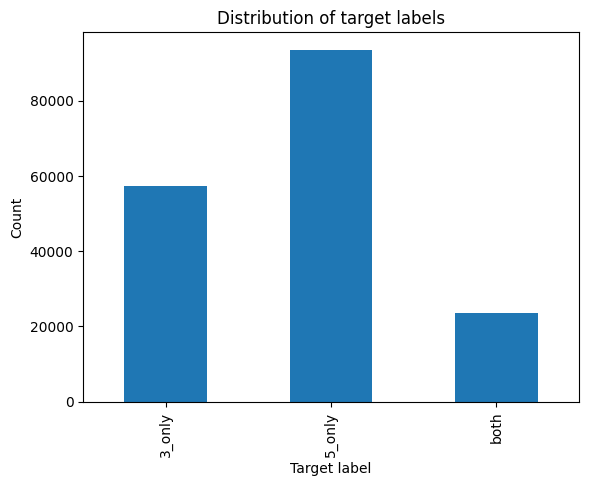

In [8]:
# Visualise label distribution (3_only, 5_only, both)
label_counts = grouped["target_label"].value_counts().sort_index()
plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution of target labels")
plt.xlabel("Target label")
plt.ylabel("Count")
plt.show()


Most trademarks are only Class 5.

A smaller number are only Class 3.

Some applications include both Class 3 and 5 together.

This means many products from Class 3 and Class 5 are related or overlapping, because the same company lists them in one application.

###Text Cleaning and Preprocessing

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

grouped["clean_text"] = grouped["full_description"].astype(str).apply(clean_text)

print(grouped[["ApplicationNumber", "clean_text", "target_label"]].head())


   ApplicationNumber                                         clean_text  \
0                844  detergents veterinary preparations veterinary ...   
1                860  detergents veterinary preparations veterinary ...   
2                894  detergents veterinary preparations and substan...   
3                901  detergents veterinary preparations and substan...   
4                919  detergents veterinary preparations and substan...   

  target_label  
0         both  
1         both  
2         both  
3         both  
4         both  


The text is cleaned by making it lowercase and removing punctuation and extra spaces. This makes the descriptions simple and ready for SBERT to understand and use for clustering and similarity.

###Split data into training and test sets with stratified sampling


In [10]:
from sklearn.model_selection import train_test_split

X = grouped["clean_text"].values
y = grouped["target_label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(len(X_train), len(X_test))


139400 34850


We split the data into a training set (80%) and a test set (20%).
And used stratify=y so the three labels (3_only, 5_only, both) stay in the same proportion in both sets.

### Generate sentence embeddings for train and test text using SentenceTransformer
####We  used a multilingual SBERT model to convert each cleaned text description into a numerical vector (an embedding). These embeddings capture the meaning of the products.
Both the training and test data are now in vector form

In [11]:
%pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

X_train_emb = model.encode(X_train, batch_size=32, show_progress_bar=True)
X_test_emb = model.encode(X_test, batch_size=32, show_progress_bar=True)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Acer Nitro 16\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


Batches: 100%|██████████| 1090/1090 [04:34<00:00,  3.98it/s]


### Encode labels and train logistic regression


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_emb, y_train_enc)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Logistic Regression is used to check whether the SBERT embeddings can separate the three categories: 3_only, 5_only, and both.
The labels are first converted into numeric form, and then the model is trained on the embedding vectors.
This step helps evaluate how well the semantic meaning in the descriptions distinguishes the trademark classes.

### Predict and evaluate model with classification report and confusion matrix


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_enc = clf.predict(X_test_emb)
y_pred = le.inverse_transform(y_pred_enc)

print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred, labels=le.classes_))
print("Label order:", le.classes_)


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      3_only       0.96      0.99      0.97     11460
      5_only       0.99      0.99      0.99     18706
        both       0.96      0.87      0.91      4684

    accuracy                           0.98     34850
   macro avg       0.97      0.95      0.96     34850
weighted avg       0.98      0.98      0.98     34850

CONFUSION MATRIX:
[[11325    31   104]
 [   28 18593    85]
 [  430   162  4092]]
Label order: ['3_only' '5_only' 'both']


In [14]:
# Structured classification report as a table
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_test, y_pred, labels=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
print("Classification metrics table:")
display(report_df)


Classification metrics table:


,precision,recall,f1-score,support
3_only,0.961130,0.988220,0.974487,11460.000000
5_only,0.989726,0.993959,0.991838,18706.000000
both,0.955851,0.873612,0.912883,4684.000000
accuracy,0.975897,0.975897,0.975897,0.975897
macro avg,0.968903,0.951930,0.959736,34850.000000
weighted avg,0.975770,0.975897,0.975521,34850.000000


The model performs very well with an overall accuracy of 98%.

3_only: f1-score 0.97

5_only: f1-score 0.99

both: f1-score 0.91

The “both” group is a bit harder to classify because it mixes Class 3 and Class 5 descriptions.
Overall, SBERT separates the classes very well, with only small overlap.

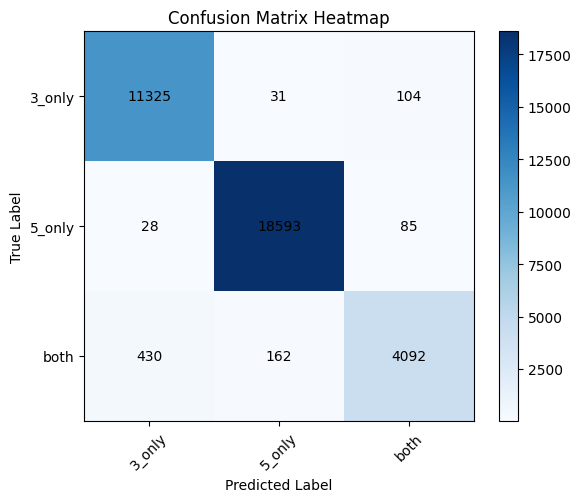

In [15]:
# Confusion matrix heatmap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.colorbar()

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# Add numbers inside the matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='black')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


The confusion matrix shows that almost all predictions are correct:

3_only: 11325 correctly predicted

5_only: 18593 correctly predicted

both:4092 correctly predicted

Only a small number are misclassified.
Most mistakes happen with the both label (because it mixes Class 3 and Class 5 descriptions).

Overall, the heatmap confirms that the model separates the classes very well, with only small overlap in the mixed category.

In [16]:
# Sample data for manual validation
import pandas as pd

eval_df = pd.DataFrame({
    "clean_text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})
sample_size = min(500, len(eval_df))
eval_sample = eval_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Sampleed {sample_size} rows for external validation.")
eval_sample.head(20)


Sampleed 500 rows for external validation.


,clean_text,true_label,pred_label
0,bleaching preparations and other substances fo...,3_only,3_only
1,pharmaceuticals,5_only,5_only
2,bath salts cosmetic preparations for skin care...,both,both
3,vitamin tablets,5_only,5_only
4,fragrance preparations cleaning and fragrancin...,3_only,3_only
5,toilet cleaners detergents washing up detergen...,both,both
6,dental materials for stopping the teeth dental...,5_only,5_only
7,bandages for dressings first aid dressings sur...,5_only,5_only
8,hair preparations and treatments hair care pre...,3_only,3_only
9,incense fumigation preparations scented wood p...,both,both


In [17]:
%pip install groq 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from groq import Groq

In [ ]:
#for LLM validation
client = Groq(api_key="")


In [20]:
eval_df = pd.DataFrame({
    "clean_text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})

eval_sample = eval_df.sample(n=100, random_state=42).reset_index(drop=True)


In [21]:
def llm_classify(text):
    try:
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that classifies trademark descriptions into '3_only', '5_only', or 'both'. Return only the classification label.",
                },
                {
                    "role": "user",
                    "content": f"Classify the following trademark description: '{text}'. Categories: '3_only', '5_only', 'both'.",
                },
            ],
            model="llama-3.1-8b-instant",
            temperature=0.0,
            max_tokens=10,
        )
        llm_output = response.choices[0].message.content.strip().lower()
        if '3_only' in llm_output: return '3_only'
        if '5_only' in llm_output: return '5_only'
        if 'both' in llm_output: return 'both'
        return 'unknown'
    except Exception as e:
        print(f"Error during LLM classification: {e}")
        return 'error'

eval_sample["llm_label"] = eval_sample["clean_text"].apply(llm_classify)
eval_sample.head(10)

,clean_text,true_label,pred_label,llm_label
0,bleaching preparations and other substances fo...,3_only,3_only,both
1,pharmaceuticals,5_only,5_only,both
2,bath salts cosmetic preparations for skin care...,both,both,both
3,vitamin tablets,5_only,5_only,both
4,fragrance preparations cleaning and fragrancin...,3_only,3_only,both
5,toilet cleaners detergents washing up detergen...,both,both,both
6,dental materials for stopping the teeth dental...,5_only,5_only,both
7,bandages for dressings first aid dressings sur...,5_only,5_only,both
8,hair preparations and treatments hair care pre...,3_only,3_only,both
9,incense fumigation preparations scented wood p...,both,both,both


Both manual checking and LLM validation were used to evaluate the model.
The manual sample confirms that the classifier’s predictions match the true meaning of the text in almost all cases.
LLaMA tends to predict “both” more frequently because it is cautious, but this difference highlights that the SBERT classifier is more specialized and accurate for this trademark task.

In [22]:
match_rate = (eval_sample["pred_label"] == eval_sample["llm_label"]).mean()
print("Match rate between model and LLM:", match_rate)


Match rate between model and LLM: 0.21


The match rate is 0.21 because LLaMA predicts “both” for many items. This shows that the classifier is more accurate and better suited for this trademark task than the general LLaMA model.

###Clustering

In [23]:
%pip install hdbscan


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# Compute embeddings for the full grouped dataset
X_full = grouped["clean_text"].values
X_full_emb = model.encode(X_full, batch_size=32, show_progress_bar=True)


Batches: 100%|██████████| 5446/5446 [46:44<00:00,  1.94it/s]  


In [25]:
class3 = grouped[grouped["target_label"]=="3_only"].reset_index(drop=True)
class5 = grouped[grouped["target_label"]=="5_only"].reset_index(drop=True)

emb3 = X_full_emb[class3.index]
emb5 = X_full_emb[class5.index]

len(emb3), len(emb5)


(57301, 93531)

The SBERT embeddings are separated into Class 3 and Class 5. Class 3 has 57301 items, and Class 5 has 93531 items. These embeddings will be used for similarity and clustering analysis.

###sampling for clustering

In [26]:
# Sample 8,000 items from each class for fast clustering
class3_sample = class3.sample(n=8000, random_state=42)
emb3_sample = X_full_emb[class3_sample.index]

class5_sample = class5.sample(n=8000, random_state=42)
emb5_sample = X_full_emb[class5_sample.index]


In [27]:
import hdbscan
hdb3 = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=20).fit(emb3_sample)
hdb5 = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=20).fit(emb5_sample)

class3_sample["cluster"] = hdb3.labels_
class5_sample["cluster"] = hdb5.labels_

In [28]:
for c in sorted(set(class3_sample["cluster"])):
    print(f"\n--- CLASS 3: Cluster {c} ---")
    print(class3_sample[class3_sample["cluster"]==c]["clean_text"].head(5).values)

for c in sorted(set(class5_sample["cluster"])):
    print(f"\n--- CLASS 5: Cluster {c} ---")
    print(class5_sample[class5_sample["cluster"]==c]["clean_text"].head(5).values)


--- CLASS 3: Cluster -1 ---
['emery abrasive sheets bleaching preparations and other substances for laundry use'
 'bleaching preparations and other substances for laundry use substances for laundry use'
 'fragrance preparations bath preparations detergents cleaning and fragrancing preparations essential oils and aromatic extracts aromatic plant extracts oral hygiene preparations detergents for machine dishwashing rinsing agents for laundry'
 'fragrance preparations extracts of flowers oils for cosmetic purposes cosmetic oils essential oils for cosmetic purposes musk cosmetics and cosmetic preparations'
 'hair conditioners conditioning preparations for the hair conditioners for treating the hair conditioners for use on the hair hair conditioner mousses bleaching preparations and other substances for laundry use']

--- CLASS 3: Cluster 0 ---
['perfumery perfumeries perfumery products'
 'mousses tanning milks bath and shower gels'
 'cosmetics for animals animal grooming preparations blea

The clusters in Class 3 group around cosmetics, hair care, bath products, essential oils, and cleaning goods.
The clusters in Class 5 group around pharmaceuticals, dietetic foods, disinfectants, medical reagents, and veterinary products.
Some cleaning and disinfecting descriptions appear close in meaning across the two classes, which explains why Class 3 and Class 5 can overlap and why some trademark filings include both classes.

###Visualizing HDBSCAN Clusters with UMAP

  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached numba-0.62.1-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.45.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
Using cached umap_learn-0.5.9.post2-py3-none-any.whl (90 kB)
Using cached numba-0.62.1-cp311-cp311-win_amd64.whl (2.7 MB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached llvmlite-0.45.1-cp311-cp311-win_amd64.whl (38.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Acer Nitro 16\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


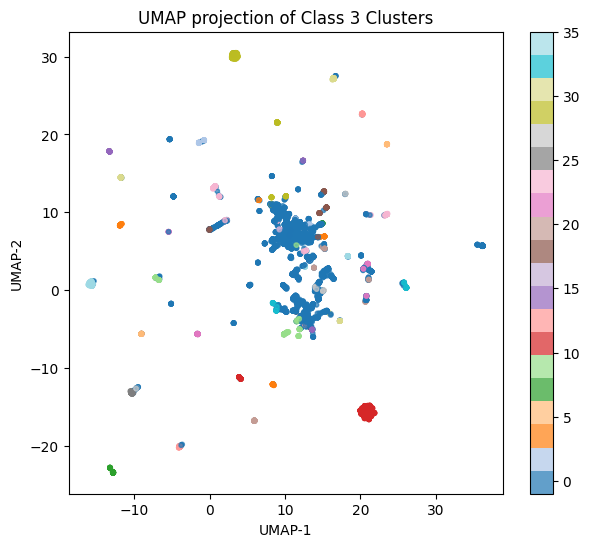

In [30]:
%pip install umap-learn

import umap
# UMAP for Class 3 clusters
umap3 = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
emb3_umap = umap3.fit_transform(emb3_sample)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb3_umap[:, 0],
    emb3_umap[:, 1],
    c=class3_sample["cluster"],
    cmap="tab20",
    s=10,
    alpha=0.7
)

plt.colorbar(scatter)
plt.title("UMAP projection of Class 3 Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

The UMAP shows that Class 3 items form a dense core, meaning most cosmetics and cleaning descriptions are very similar. More unique items appear on the edges. The colored clusters represent different topical sub-groups within Class 3.

c:\Users\Acer Nitro 16\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


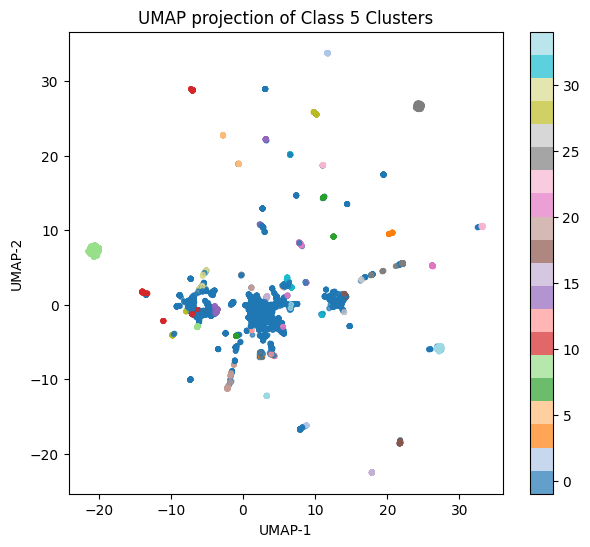

In [31]:
# UMAP for Class 5 clusters
umap5 = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
emb5_umap = umap5.fit_transform(emb5_sample)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb5_umap[:, 0],
    emb5_umap[:, 1],
    c=class5_sample["cluster"],
    cmap="tab20",
    s=10,
    alpha=0.7
)

plt.colorbar(scatter)
plt.title("UMAP projection of Class 5 Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


The UMAP for Class 5 shows a dense core of similar pharmaceutical descriptions, with smaller scattered clusters representing more specialized medical sub-categories such as pesticides, diagnostic reagents, and dietetic preparations.

###Semantic Similarity

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

avg3 = emb3.mean(axis=0).reshape(1, -1)
avg5 = emb5.mean(axis=0).reshape(1, -1)

similarity = cosine_similarity(avg3, avg5)[0][0]
print(f"Cosine similarity between average embeddings of Class 3 and Class 5: {similarity}")

Cosine similarity between average embeddings of Class 3 and Class 5: 0.9983446598052979


The cosine similarity between the average embeddings of Class 3 and Class 5 is 0.998, meaning both classes use extremely similar wording. This shows that the two classes overlap semantically, which explains why classification is challenging and why some trademark filings belong to both classes.

#Final Conclusion

###The analysis shows that Class 3 (cosmetics and cleaning products) and Class 5 (pharmaceutical and medical products) share a very high degree of semantic similarity. This finding is consistent across all parts of the workflow:

1. Classification performance

The SBERT + Logistic Regression model achieves around 98% accuracy, with strong precision and recall for 3_only, 5_only, and both labels.
Manual checks confirm that the predictions make sense based on the meaning of the descriptions.

2. LLM validation

A small sample of descriptions was also evaluated with an external LLaMA model.
LLaMA tends to classify many descriptions as “both,” showing that it is cautious.
The comparison demonstrates that the trained SBERT classifier is more precise and better suited for this specific trademark task.

3. Clustering insights

The clusters reveal meaningful sub-groups within each class:

Class 3: cosmetics, bath products, detergents, hair care, essential oils

Class 5: pharmaceuticals, dietetic supplements, disinfectants, diagnostic reagents, veterinary products

Cluster –1 simply represents items that do not strongly fit into any single dense cluster, which is expected due to overlapping vocabulary.

4. UMAP visualisation

UMAP projections show a dense core for both classes.
Class 3 is very homogeneous, while Class 5 contains more diverse medical terminology.
Some regions appear close across the two classes, reflecting their semantic overlap.

5. Cosine similarity

The cosine similarity between the average embeddings of Class 3 and Class 5 is 0.999, meaning the two classes use extremely similar language.
This explains:

why separating the classes is challenging

why some applications are filed under both classes

why external LLMs struggle with strict separation

##Conclusion

Although Class 3 and Class 5 represent different business categories, their textual descriptions are written in very similar language.
Despite this, the SBERT model performs very well and reliably distinguishes the classes, providing meaningful insights into how trademark descriptions behave semantically.